In [3]:
import cv2 as cv
import os
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as mpl
import seaborn as sns
import pickle
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

In [12]:
trainval = './CatVsDog/annotations/trainval.txt'
testval = './CatVsDog/annotations/test.txt'

In [17]:
def read_filenames(path):
    with open(path) as f:
        lines = f.readlines()

    names = [x.split(' ')[0] for x in lines]
    full_names = [os.path.join('./images/', x)+'.jpg' for x in names]
    return full_names, names

In [18]:
train_files, train_names = read_filenames(trainval)
test_files, test_names = read_filenames(testval)
dataset = pd.DataFrame(data={'file': train_files+test_files,
                             'name': train_names+test_names,
                             'split': ['train']*len(train_files)+['test']*len(test_files)})
names_path='./CatVsDog/annotations/list.txt'
names=dict()
with open(names_path) as f:
    for line in f.readlines()[6:]:
        name,_,cl,_=line.split()
        names[name]=cl
dataset['class'] = dataset.apply(lambda r: names[r['name']], axis=1)
dataset.sample(4)

,file,name,split,class
1115,./images/newfoundland_118.jpg,newfoundland_118,train,2
3795,./images/american_bulldog_23.jpg,american_bulldog_23,test,2
260,./images/Bengal_10.jpg,Bengal_10,train,1
5502,./images/keeshond_46.jpg,keeshond_46,test,2


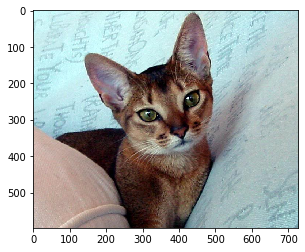

In [20]:
img = cv.imread("images/Abyssinian_51.jpg")
mpl.imshow(img[:,:,::-1]);

In [21]:
def preprocess(img,size=(100,100)):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    resized=cv.resize(gray,size)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    normalized = clahe.apply(resized)
    return normalized

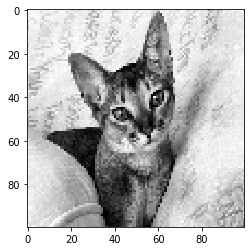

In [22]:
# img = cv.imread(dataset.sample(1).iloc[0]['file'])
img=preprocess(img)
mpl.imshow(img,cmap='gray');

In [23]:
def generatte_filters(ksize=5,phi=0):
    kernels=[]
    lables=[]
    for theta in range(4):
        theta=theta/4.*np.pi
        for sigma in(1,3,5):
            for lamda in np.arange(0,np.pi,np.pi/4):
                for gamma in(0.05,0.5):
                    label = "Gabor "+" ".join(str(x) for x in[theta,sigma,lamda,gamma])
                    kernel=cv.getGaborKernel((ksize,ksize),sigma,theta,lamda,gamma,phi,ktype=cv.CV_32F)
                    if np.isnan(kernel[0][0]):continue
                    kernels.append(kernel)
                    lables.append(label)
    return kernels,lables
k,l=generatte_filters()

In [24]:
def appply_filter(img,kernels,lables):
    df=pd.DataFrame()
    df['Original Image']=img.reshape(-1)
    raw_features=[]
    for kernel,label in zip(kernels,lables):
        fimg = cv.filter2D(img,cv.CV_8UC3,kernel)
        raw_features.append(fimg)
        df[label]=fimg.reshape(-1)
    return df,raw_features      

In [25]:
d,f=appply_filter(img,k,l)

In [26]:
d.head(20)

,Original Image,Gabor 0.0 1 0.7853981633974483 0.05,Gabor 0.0 1 0.7853981633974483 0.5,Gabor 0.0 1 1.5707963267948966 0.05,Gabor 0.0 1 1.5707963267948966 0.5,Gabor 0.0 1 2.356194490192345 0.05,Gabor 0.0 1 2.356194490192345 0.5,Gabor 0.0 3 0.7853981633974483 0.05,Gabor 0.0 3 0.7853981633974483 0.5,Gabor 0.0 3 1.5707963267948966 0.05,...,Gabor 2.356194490192345 3 1.5707963267948966 0.05,Gabor 2.356194490192345 3 1.5707963267948966 0.5,Gabor 2.356194490192345 3 2.356194490192345 0.05,Gabor 2.356194490192345 3 2.356194490192345 0.5,Gabor 2.356194490192345 5 0.7853981633974483 0.05,Gabor 2.356194490192345 5 0.7853981633974483 0.5,Gabor 2.356194490192345 5 1.5707963267948966 0.05,Gabor 2.356194490192345 5 1.5707963267948966 0.5,Gabor 2.356194490192345 5 2.356194490192345 0.05,Gabor 2.356194490192345 5 2.356194490192345 0.5
0,249,255,255,216,173,108,86,0,0,0,...,122,101,255,255,255,255,123,115,255,255
1,250,255,255,198,160,84,69,0,0,0,...,148,127,255,255,255,255,149,141,255,255
2,244,255,255,224,176,116,91,0,0,0,...,99,80,255,237,255,255,99,92,255,255
3,249,255,255,194,153,80,63,0,0,0,...,146,127,255,253,255,255,147,140,255,255
4,249,255,255,218,176,107,87,0,0,0,...,137,116,255,255,255,255,139,131,255,255
5,247,255,255,214,173,109,90,0,0,0,...,110,90,255,245,255,255,110,103,255,255
6,243,255,255,164,125,56,39,0,0,0,...,129,111,255,245,255,255,129,122,255,255
7,249,255,255,223,179,120,99,0,0,0,...,83,66,252,226,255,255,81,75,255,255
8,237,255,255,198,158,93,73,0,0,0,...,145,124,255,228,255,255,148,140,255,255
9,238,255,255,172,143,73,63,0,0,0,...,133,113,255,250,255,255,134,127,255,255


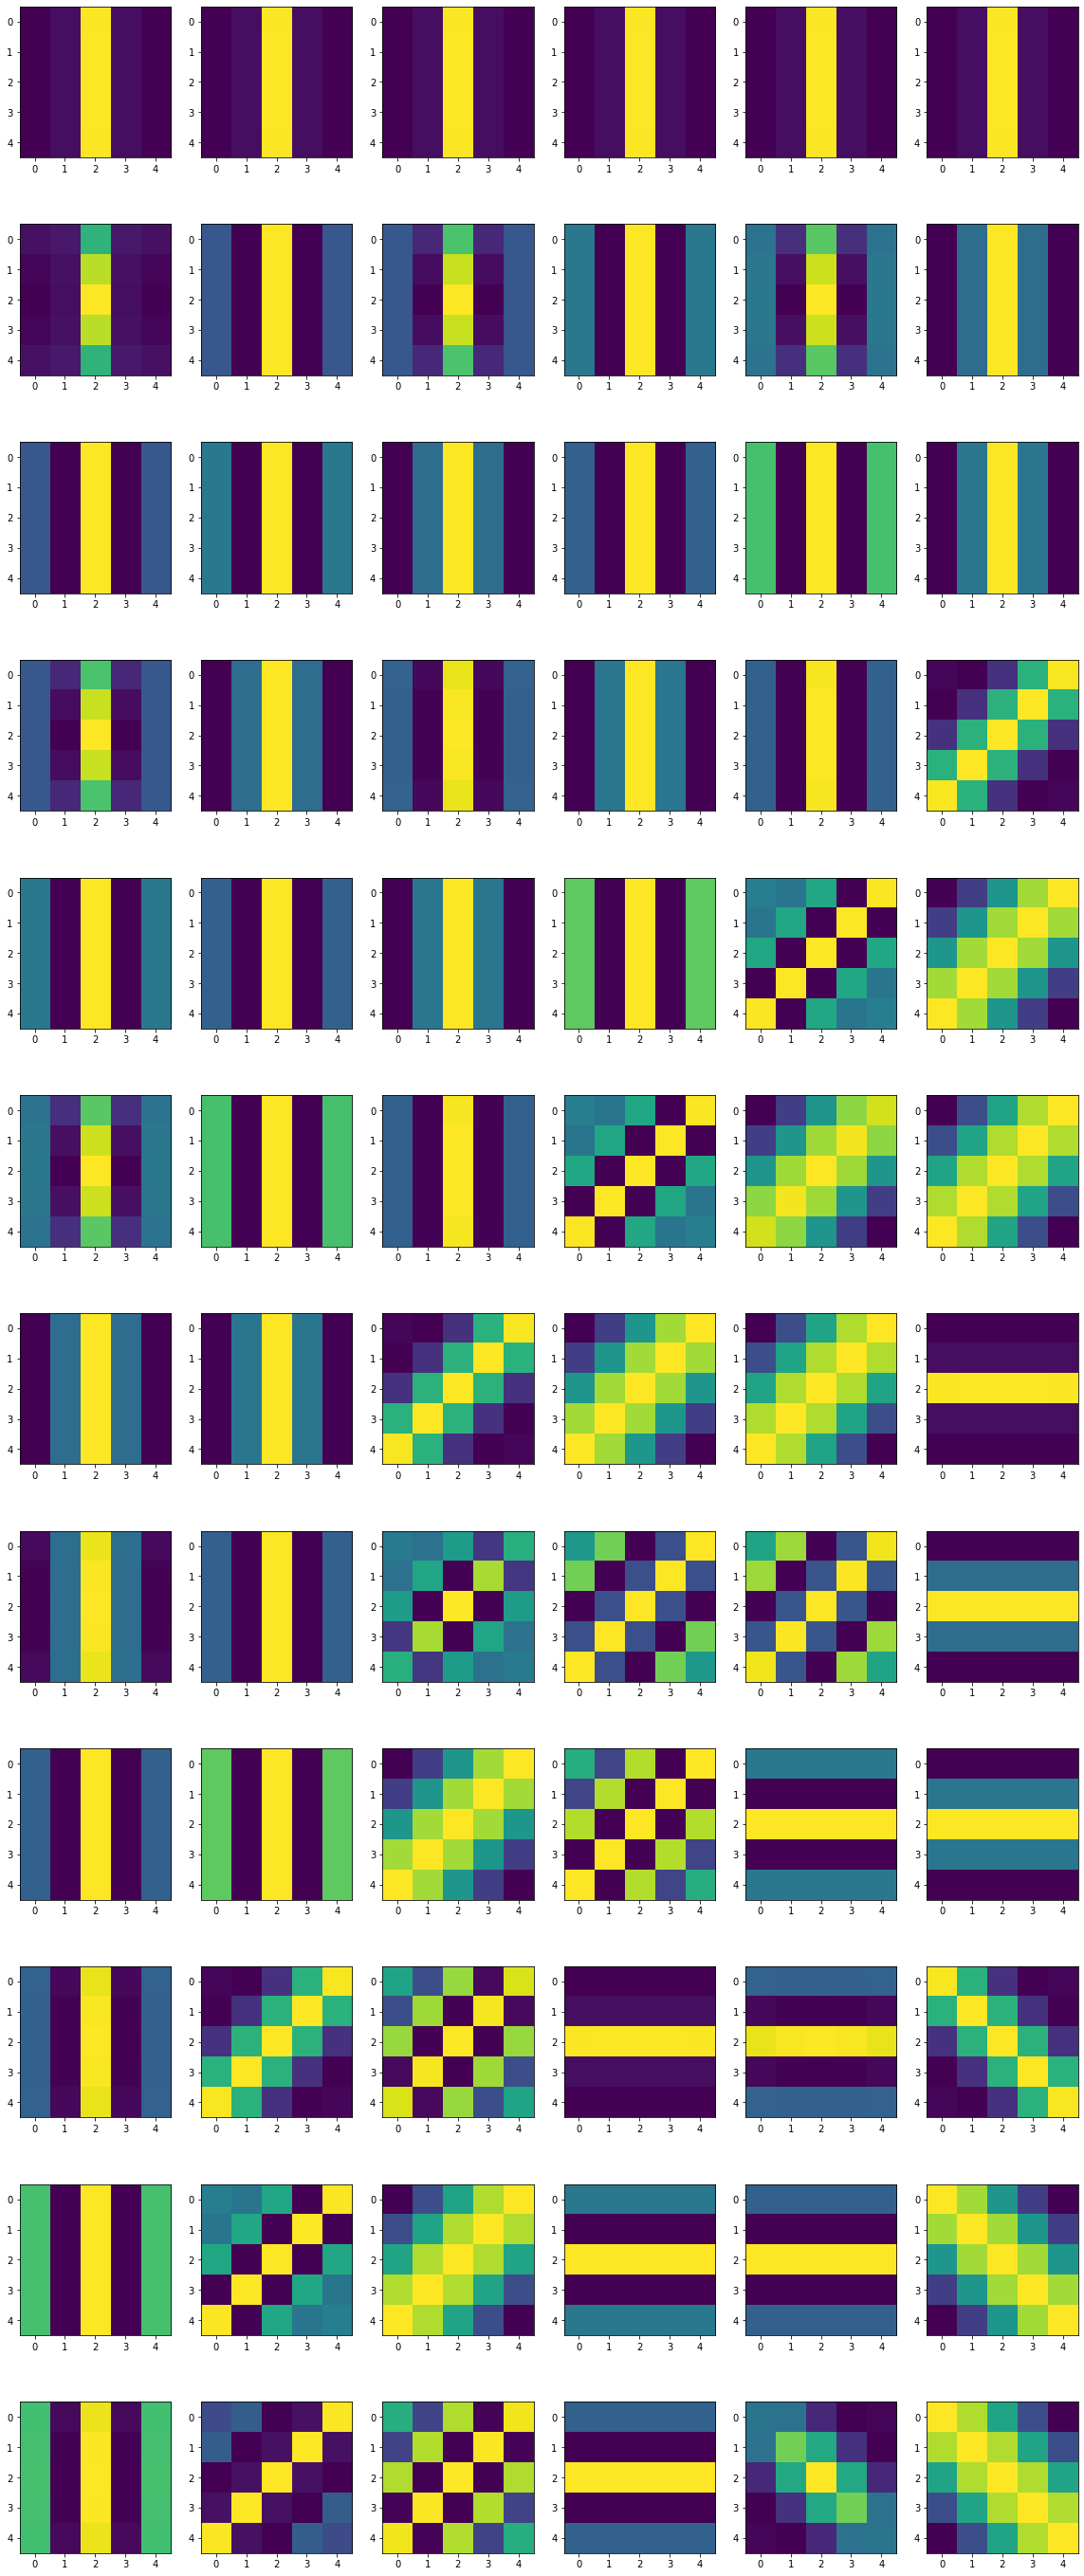

In [27]:
rows=int(np.ceil(len(k)/6))
fig, axs = mpl.subplots(rows, 6,figsize=(20,50))
for i in range(6):
    for j in range(rows):
        axs[j,i].imshow(k[j*(i+1)])

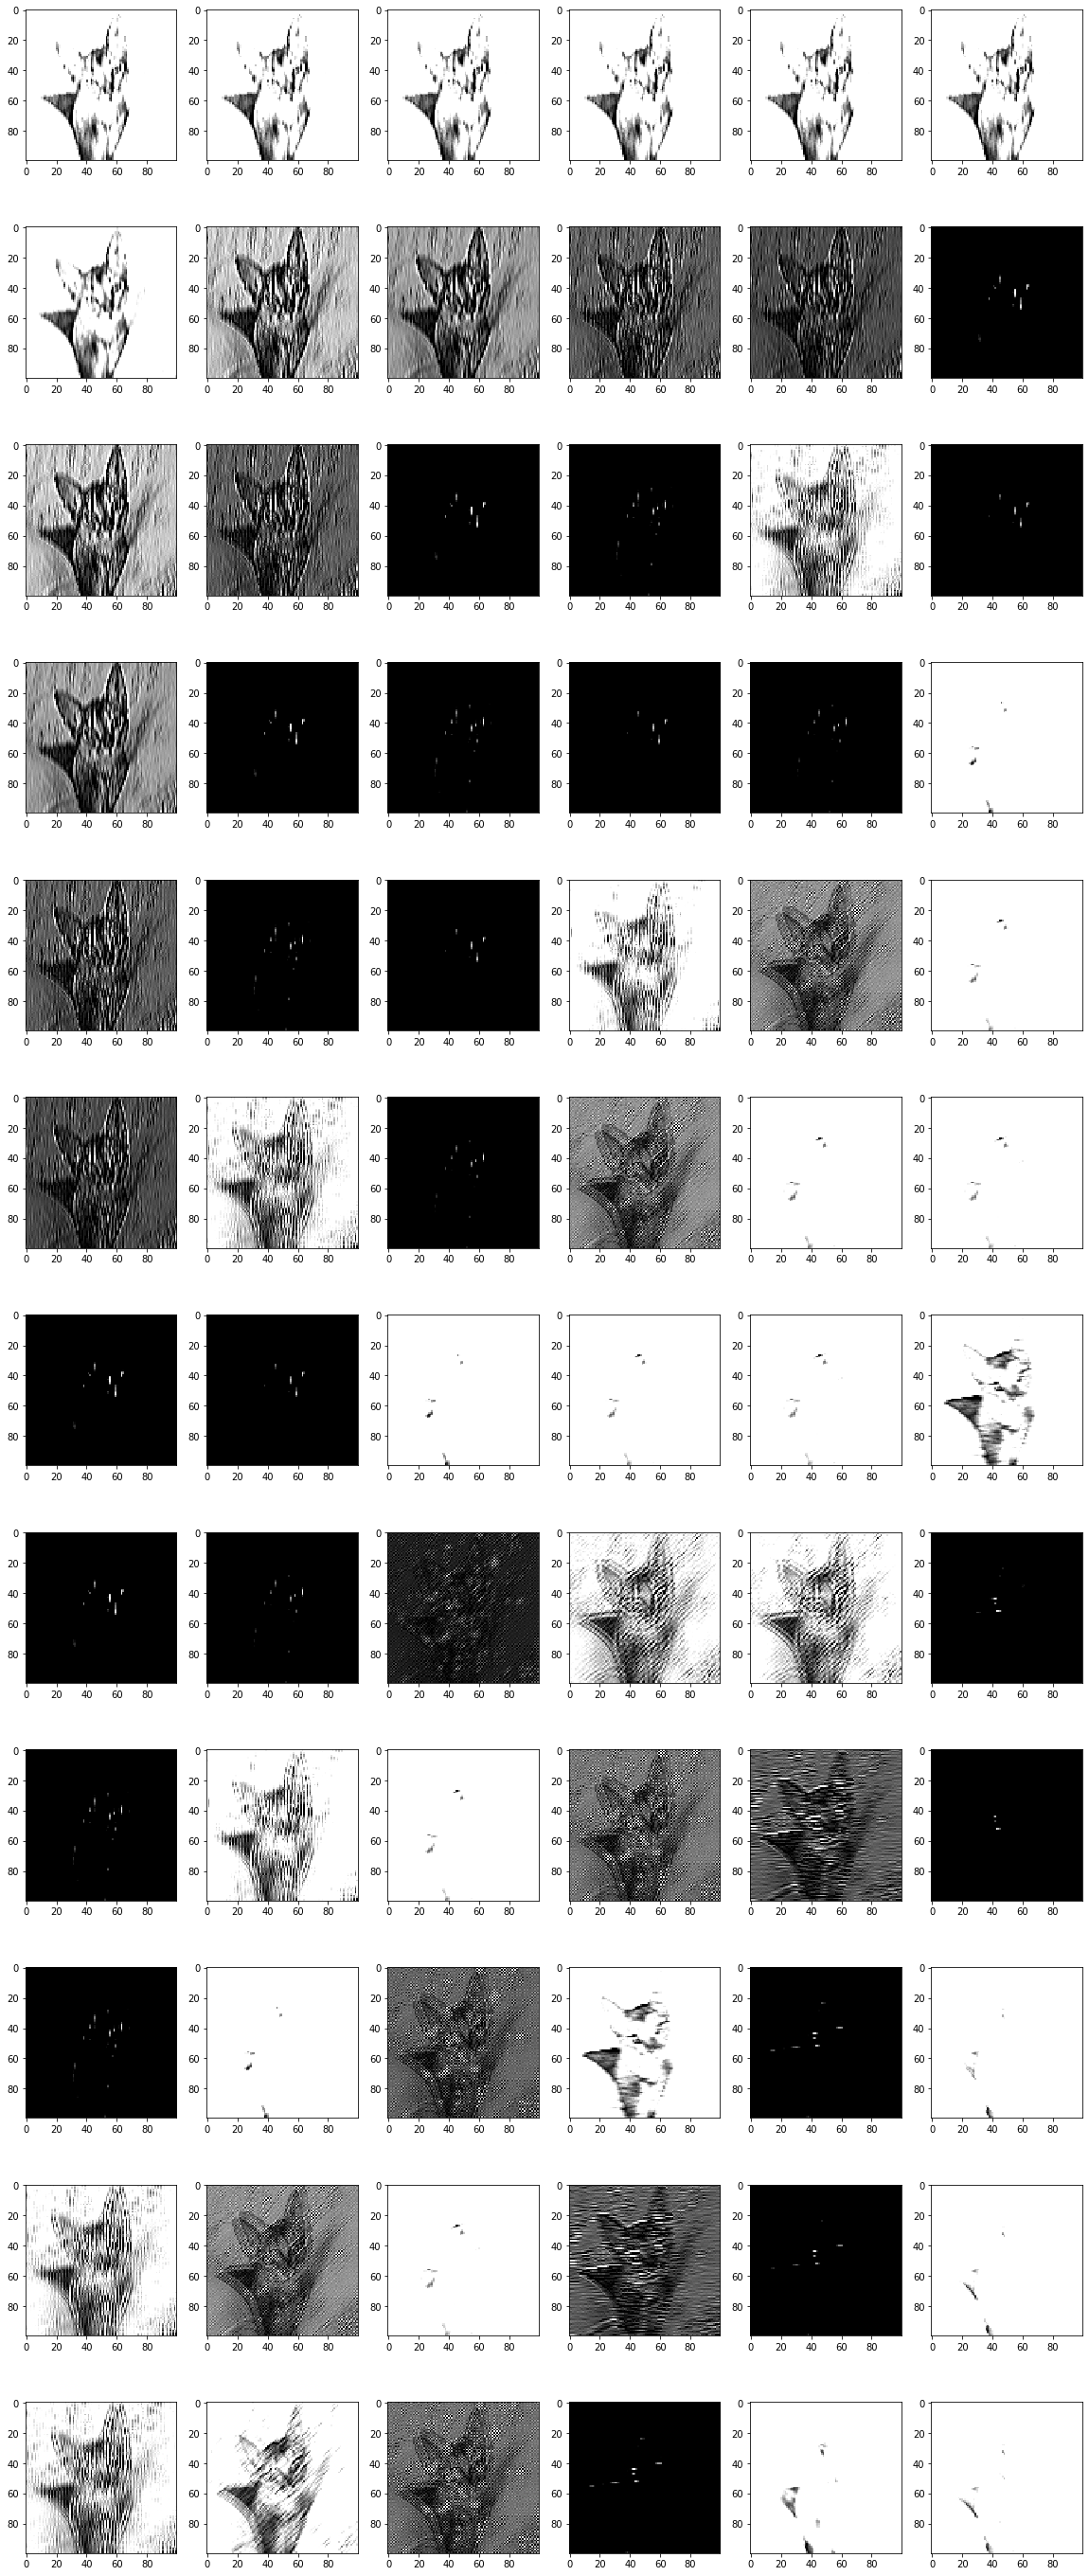

In [29]:
rows=int(np.ceil(len(k)/6))
fig, axs = mpl.subplots(rows, 6,figsize=(20,50))
for i in range(6):
    for j in range(rows):
        axs[j,i].imshow(f[j*(i+1)],cmap='gray')

In [14]:
d.iloc[:,0]

0       195
1       186
2       198
3       196
4       189
       ... 
9995    145
9996     98
9997     79
9998     75
9999     94
Name: Original Image, Length: 10000, dtype: uint8

In [15]:
d.shape

(10000, 73)

In [16]:
d.to_numpy().T

array([[195, 186, 198, ...,  79,  75,  94],
       [255, 255, 255, ..., 255,   7, 110],
       [255, 255, 255, ..., 235,  19, 107],
       ...,
       [120,  74, 143, ...,  72,  38, 250],
       [227, 183, 192, ...,  45, 255, 255],
       [220, 176, 185, ...,  43, 255, 255]], dtype=uint8)

In [17]:
train_dataframe=dataset[dataset['split']=='train']
test_dataframe=dataset[dataset['split']=='test']

In [18]:
train_dataframe

,file,name,split,class
0,./CatVsDog/images/Abyssinian_100.jpg,Abyssinian_100,train,1
1,./CatVsDog/images/Abyssinian_101.jpg,Abyssinian_101,train,1
2,./CatVsDog/images/Abyssinian_102.jpg,Abyssinian_102,train,1
3,./CatVsDog/images/Abyssinian_103.jpg,Abyssinian_103,train,1
4,./CatVsDog/images/Abyssinian_104.jpg,Abyssinian_104,train,1
...,...,...,...,...
3675,./CatVsDog/images/yorkshire_terrier_187.jpg,yorkshire_terrier_187,train,2
3676,./CatVsDog/images/yorkshire_terrier_188.jpg,yorkshire_terrier_188,train,2
3677,./CatVsDog/images/yorkshire_terrier_189.jpg,yorkshire_terrier_189,train,2
3678,./CatVsDog/images/yorkshire_terrier_18.jpg,yorkshire_terrier_18,train,2


In [19]:
test_dataframe

,file,name,split,class
3680,./CatVsDog/images/Abyssinian_201.jpg,Abyssinian_201,test,1
3681,./CatVsDog/images/Abyssinian_202.jpg,Abyssinian_202,test,1
3682,./CatVsDog/images/Abyssinian_204.jpg,Abyssinian_204,test,1
3683,./CatVsDog/images/Abyssinian_205.jpg,Abyssinian_205,test,1
3684,./CatVsDog/images/Abyssinian_206.jpg,Abyssinian_206,test,1
...,...,...,...,...
7344,./CatVsDog/images/yorkshire_terrier_96.jpg,yorkshire_terrier_96,test,2
7345,./CatVsDog/images/yorkshire_terrier_97.jpg,yorkshire_terrier_97,test,2
7346,./CatVsDog/images/yorkshire_terrier_98.jpg,yorkshire_terrier_98,test,2
7347,./CatVsDog/images/yorkshire_terrier_99.jpg,yorkshire_terrier_99,test,2


In [20]:
def form_data(frame,size=(64,64)):
    kernels,lables=generatte_filters()
    X=[]
    Y=[]
    for i in range(frame.shape[0]):
        try:
            im=cv.imread(frame['file'][i])
        except:
            print(frame['file'][i])
            continue
        cls=[int(frame['class'][i])]
        proc_im=preprocess(im,size)
        data_f,raw_features=appply_filter(proc_im,kernels,lables)
        feat_array=np.array(data_f.to_numpy().T)
        X.append(feat_array)
        Y.append(cls*data_f.shape[1])
    X=np.array(X)
    Y=np.array(Y)
    X=X.reshape(-1,X.shape[-1])
    Y=Y.reshape(-1)
    return X,Y

In [21]:
X_train,Y_train=form_data(train_dataframe,(32,32))
# X_test,Y_test=form_data(test_dataframe)

In [22]:
X_train.shape

(268640, 1024)

In [23]:
Y_train.shape

(268640,)

In [24]:
i =0 
while Y_train[i] ==1:
    i+=1
i

3650

In [25]:
train_dr=pd.DataFrame(X_train)
train_dr["Y"]=Y_train
train_dr
# test_dr=DataFrame(X_test)
# train_dr["Y"]=Y_test
# train_dr

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,Y
0,32,48,143,147,128,147,112,96,160,211,...,60,48,64,32,219,255,223,80,96,1
1,255,255,255,255,255,255,255,255,255,255,...,60,219,253,255,255,255,255,255,255,1
2,255,255,255,255,255,255,255,255,255,255,...,37,185,185,255,255,255,255,255,255,1
3,91,107,235,155,149,133,161,98,147,178,...,0,114,0,202,255,144,255,95,145,1
4,110,47,198,124,110,107,130,60,112,146,...,0,107,0,125,235,114,255,65,113,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268635,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,2
268636,0,241,0,185,0,64,0,124,0,115,...,255,19,255,0,132,191,19,255,0,2
268637,0,235,0,178,0,59,0,122,0,109,...,255,15,255,0,127,184,10,255,0,2
268638,231,124,255,255,255,255,225,6,144,255,...,172,22,177,255,255,160,255,255,160,2


In [26]:
train_dr.to_csv('gabor_dogsCats32_train.csv',index=False)

In [27]:
train_dr

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,Y
0,32,48,143,147,128,147,112,96,160,211,...,60,48,64,32,219,255,223,80,96,1
1,255,255,255,255,255,255,255,255,255,255,...,60,219,253,255,255,255,255,255,255,1
2,255,255,255,255,255,255,255,255,255,255,...,37,185,185,255,255,255,255,255,255,1
3,91,107,235,155,149,133,161,98,147,178,...,0,114,0,202,255,144,255,95,145,1
4,110,47,198,124,110,107,130,60,112,146,...,0,107,0,125,235,114,255,65,113,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268635,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,2
268636,0,241,0,185,0,64,0,124,0,115,...,255,19,255,0,132,191,19,255,0,2
268637,0,235,0,178,0,59,0,122,0,109,...,255,15,255,0,127,184,10,255,0,2
268638,231,124,255,255,255,255,225,6,144,255,...,172,22,177,255,255,160,255,255,160,2


In [9]:
tr=pd.read_csv('gabor_dogsCats32_train.csv',dtype='uint8')

In [10]:
tr_full=tr
tr=tr.iloc[:25000,:]

In [11]:
train_XY,testXY=train_test_split(tr,test_size=0.25)

In [12]:
temp_train_X=train_XY.to_numpy()[:,:-1]
temp_train_Y=train_XY.to_numpy()[:,-1]

In [13]:
temp_train_X.shape
type(temp_train_Y)

numpy.ndarray

In [15]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto',verbose=True))
clf.fit(temp_train_X, temp_train_Y)

[LibSVM]

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', verbose=True))])

In [16]:
#clf=pickle.load(open("SVMmodel", 'rb'))

In [17]:
temp_test_X=testXY.to_numpy()[:,:-1]
temp_test_Y=testXY.to_numpy()[:,-1]

In [18]:
pred=clf.predict(temp_test_X)

In [19]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(temp_test_Y, pred)

In [61]:
def plot_cm(cm):
    ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    mpl.show()

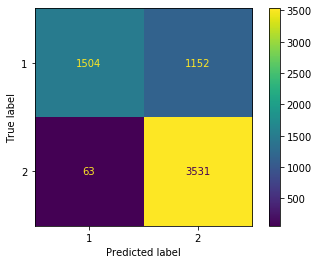

In [22]:
plot_confusion_matrix(clf,temp_test_X,temp_test_Y);

In [23]:
pickle.dump(clf, open("SVMmodel", 'wb'))

In [25]:
#81%

In [26]:
from sklearn.ensemble import RandomForestClassifier
randomForestCls=RandomForestClassifier(n_estimators=100)

In [27]:
randomForestCls.fit(temp_train_X, temp_train_Y)

RandomForestClassifier()

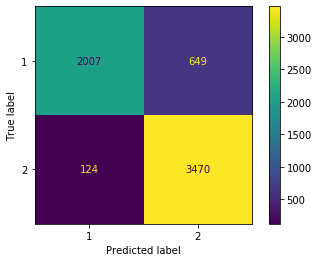

In [30]:
ConfusionMatrixDisplay.from_estimator(randomForestCls,temp_test_X,temp_test_Y);

In [31]:
#88%

In [32]:
pickle.dump(randomForestCls, open("RFModel", 'wb'))

In [34]:
MLCFFmodel = MLPClassifier(activation='relu',solver='adam',hidden_layer_sizes=(16*16,8*8,4*4),
                           random_state=1, max_iter=300,verbose=True)

In [35]:
MLCFFmodel.fit(temp_train_X, temp_train_Y)

Iteration 1, loss = 2.45974926
Iteration 2, loss = 0.65864037
Iteration 3, loss = 0.63882370
Iteration 4, loss = 0.62445288
Iteration 5, loss = 0.61023891
Iteration 6, loss = 0.59813858
Iteration 7, loss = 0.58510676
Iteration 8, loss = 0.57464180
Iteration 9, loss = 0.56560922
Iteration 10, loss = 0.55873595
Iteration 11, loss = 0.55454144
Iteration 12, loss = 0.55051787
Iteration 13, loss = 0.54815956
Iteration 14, loss = 0.54617329
Iteration 15, loss = 0.54620823
Iteration 16, loss = 0.54410191
Iteration 17, loss = 0.54433605
Iteration 18, loss = 0.54289534
Iteration 19, loss = 0.54200829
Iteration 20, loss = 0.54234259
Iteration 21, loss = 0.54161107
Iteration 22, loss = 0.54123999
Iteration 23, loss = 0.54103589
Iteration 24, loss = 0.54205809
Iteration 25, loss = 0.55477781
Iteration 26, loss = 0.55025785
Iteration 27, loss = 0.54431808
Iteration 28, loss = 0.54085240
Iteration 29, loss = 0.54095519
Iteration 30, loss = 0.53895220
Iteration 31, loss = 0.54098330
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(256, 64, 16), max_iter=300, random_state=1,
              verbose=True)

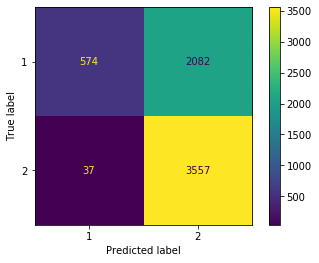

In [36]:
ConfusionMatrixDisplay.from_estimator(MLCFFmodel,temp_test_X,temp_test_Y);

In [37]:
#66%

In [39]:
MLCFFmodel3layer.fit(temp_train_X, temp_train_Y)

Iteration 1, loss = 10.17349384
Iteration 2, loss = 5.50929836
Iteration 3, loss = 3.60851276
Iteration 4, loss = 2.40940405
Iteration 5, loss = 1.38659805
Iteration 6, loss = 0.77866473
Iteration 7, loss = 0.56062919
Iteration 8, loss = 0.45713061
Iteration 9, loss = 0.37301460
Iteration 10, loss = 0.32432791
Iteration 11, loss = 0.30425220
Iteration 12, loss = 0.27691209
Iteration 13, loss = 0.25215086
Iteration 14, loss = 0.23842451
Iteration 15, loss = 0.23792752
Iteration 16, loss = 0.23265661
Iteration 17, loss = 0.21750901
Iteration 18, loss = 0.20412161
Iteration 19, loss = 0.21338177
Iteration 20, loss = 0.24973226
Iteration 21, loss = 0.23467654
Iteration 22, loss = 0.20796545
Iteration 23, loss = 0.19492595
Iteration 24, loss = 0.19498670
Iteration 25, loss = 0.18966674
Iteration 26, loss = 0.20248096
Iteration 27, loss = 0.19990851
Iteration 28, loss = 0.19363625
Iteration 29, loss = 0.21389753
Iteration 30, loss = 0.19852973
Iteration 31, loss = 0.21742995
Iteration 32, lo

MLPClassifier(hidden_layer_sizes=(256,), max_iter=300, random_state=1,
              verbose=True)

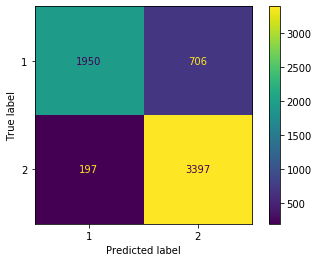

In [40]:
ConfusionMatrixDisplay.from_estimator(MLCFFmodel3layer,temp_test_X,temp_test_Y);

In [41]:
#86%

In [42]:
pickle.dump(MLCFFmodel3layer, open("MLCFFmodel3layer_from_paper", 'wb'))

In [44]:
Gausian=GaussianNB()

In [45]:
Gausian.fit(temp_train_X, temp_train_Y)

GaussianNB()

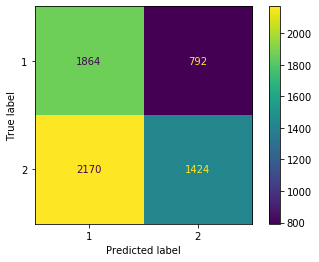

In [47]:
ConfusionMatrixDisplay.from_estimator(Gausian,temp_test_X,temp_test_Y);

In [49]:
#52%

In [51]:
BialMultyClf = MultinomialNB()

In [53]:
BialMultyClf.fit(temp_train_X, temp_train_Y)

MultinomialNB()

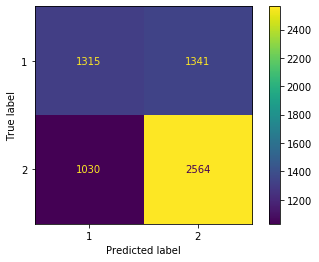

In [54]:
ConfusionMatrixDisplay.from_estimator(BialMultyClf,temp_test_X,temp_test_Y);

In [55]:
#62%

In [57]:
bernouliClf=BernoulliNB()

In [58]:
bernouliClf.fit(temp_train_X, temp_train_Y)

BernoulliNB()

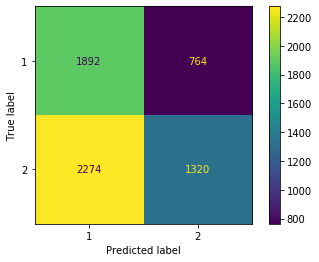

In [59]:
ConfusionMatrixDisplay.from_estimator(bernouliClf,temp_test_X,temp_test_Y);

In [60]:
#51%